# Caso: Modelo de Predicción Climática en Australia

## Objetivo
El objetivo de este caso  es construir un modelo que permita predecir si mañana va a llover (o no) en Australia en función a mediciones climáticas históricas.

Recursos Adicionales

- [scikit-learn documentación de árboles de decisión](http://scikit-learn.org/stable/modules/tree.html)
- [Gini Vs Entropia](http://www.garysieling.com/blog/sklearn-gini-vs-entropy-criteria)

## 1. Análisis descriptivo del dataset

El set de entrenamiento a utilizar es **weatheraus_entrenamiento.csv** el cual contiene información sobre 51.785 mediciones climáticas realizadas en distintos lugares de Australia. En el archivo **Diccionario-Wheather-AUS** se especifica la descripción de cada uno de sus atributos y algunas aclaraciones sobre la información suministrada.

La variable target es **RainTomorrow**, que especifica si llueve o no el día siguiente.

Descripción más detallada del dataset:
  http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

In [8]:
# Librerias a importar
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Por defecto, matplotlib crea una figura en una ventana separada. Cuando usamos notebooks, podemos hacer que las
# figuras aparezcan en línea dentro del notebook. Esto lo hacemos ejecutando:
%matplotlib inline

from IPython.display import Image

# Scikit-learn (sklearn) es una librería que implementa algunos algoritmos de Machine Learning y pre-procesamiento de datos.
from sklearn.tree import export_graphviz

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


In [9]:
# Leemos el dataset de entrenamiento
dataset_entrenamiento='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/weather_aus_entrenamiento.csv'
df = pd.read_csv(dataset_entrenamiento, sep =',', na_values = '.', parse_dates=["Date"])

# Para estandarizar el análisis, llamaremos variable "CLASE" a la variable target
df['CLASE'] = df['RainTomorrow']
df.drop(["RainTomorrow"], axis=1, inplace=True)

df.head(5)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0 2014-01-01   Albury     12.0     27.4       0.0          NaN       NaN   
1 2014-01-02   Albury     16.7     27.7       0.0          NaN       NaN   
2 2014-01-03   Albury     18.9     30.6       0.2          NaN       NaN   
3 2014-01-04   Albury     13.1     25.6       0.0          NaN       NaN   
4 2014-01-05   Albury      8.4     29.4       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0         WNW           43.0        SSE  ...        56.0         38.0   
1           W           31.0        WNW  ...        61.0         22.0   
2         WSW           44.0        ENE  ...        40.0         32.0   
3           W           46.0        WSW  ...        46.0         28.0   
4         WNW           65.0         SE  ...        50.0         24.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1011.1       1008.6       NaN       1.0     20.3     25.9         No   
1       1006.1       1005.8       1.0       1.0     22.3     26.4         No   
2       1003.1        999.1       8.0       8.0     22.3     27.5         No   
3       1006.8       1005.7       NaN       4.0     16.8     24.2         No   
4       1009.4       1004.5       NaN       1.0     18.7     28.9         No   

   CLASE  
0     No  
1     No  
2     No  
3     No  
4     No  

[5 rows x 23 columns]

#### **Descripción Estadística General**
- **Consigna**: ¿Qué información relevante obtenemos de este primer análisis?

In [10]:
# ¿Qué información estadística obtenemos del dataset?
df.describe()

Date       MinTemp       MaxTemp  \
count                          51785  51565.000000  51664.000000   
mean   2015-07-29 12:40:10.056966400     12.849993     24.090934   
min              2014-01-01 00:00:00     -8.200000     -4.100000   
25%              2014-09-29 00:00:00      8.300000     18.800000   
50%              2015-06-30 00:00:00     12.900000     23.700000   
75%              2016-03-30 00:00:00     17.500000     29.300000   
max              2017-06-25 00:00:00     31.900000     47.300000   
std                              NaN      6.470900      7.285033   

           Rainfall   Evaporation      Sunshine  WindGustSpeed  WindSpeed9am  \
count  51255.000000  25248.000000  22297.000000   48842.000000  51335.000000   
mean       2.203551      5.993013      7.743149      39.226342     13.596766   
min        0.000000      0.000000      0.000000       7.000000      0.000000   
25%        0.000000      3.000000      5.000000      30.000000      7.000000   
50%        0.000000      5.200000      8.700000      37.000000     13.000000   
75%        0.600000      8.000000     10.800000      46.000000     19.000000   
max      247.200000     74.800000     14.500000     135.000000    130.000000   
std        8.258435      4.632820      3.779734      13.151715      8.663309   

       WindSpeed3pm   Humidity9am   Humidity3pm   Pressure9am   Pressure3pm  \
count  50407.000000  51300.000000  49866.000000  46076.000000  46081.000000   
mean      18.178249     68.999708     50.862010   1018.224481   1015.784833   
min        0.000000      2.000000      0.000000    982.200000    981.400000   
25%       11.000000     57.000000     35.000000   1013.500000   1010.900000   
50%       17.000000     70.000000     51.000000   1018.100000   1015.700000   
75%       24.000000     84.000000     65.000000   1022.900000   1020.500000   
max       83.000000    100.000000    100.000000   1040.300000   1037.300000   
std        8.602124     19.394990     21.106463      7.060412      7.038569   

           Cloud9am      Cloud3pm       Temp9am       Temp3pm  
count  30862.000000  29052.000000  51624.000000  50206.000000  
mean       4.592897      4.537416     17.596019     22.487828  
min        0.000000      0.000000     -7.000000     -4.400000  
25%        1.000000      2.000000     12.900000     17.400000  
50%        5.000000      5.000000     17.500000     22.100000  
75%        7.000000      7.000000     22.200000     27.400000  
max        8.000000      8.000000     40.200000     46.700000  
std        2.909026      2.770267      6.600460      7.104586

CLASE
No     78.935985
Yes    21.064015
Name: proportion, dtype: float64
CLASE
No     40877
Yes    10908
Name: count, dtype: int64


/tmp/ipython-input-736050130.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CLASE', data=df,  palette="cubehelix")


<Axes: xlabel='CLASE', ylabel='count'>

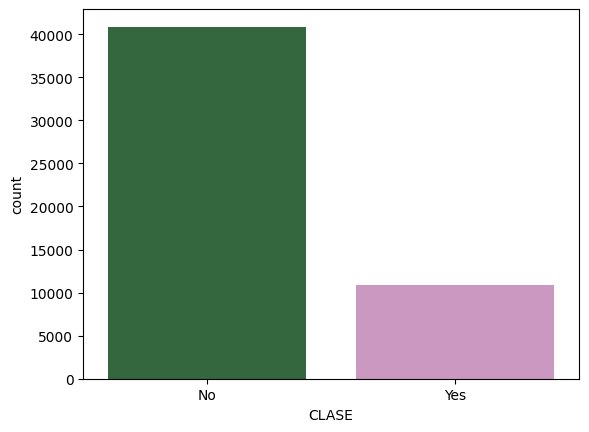

In [11]:
# Veamos la distribución de la variable target
print(df['CLASE'].value_counts(normalize = True)*100) # expresado en porcentajes
print(df['CLASE'].value_counts(normalize = False)) # expresado en nominal

sns.countplot(x='CLASE', data=df,  palette="cubehelix")

### 1.a) Análisis de Missing Values o Nulos

Analizamos la existencia de valores faltantes y seleccionamos la estrategia de imputación.

In [12]:
val_nulos = df.isnull().sum()
print(df.shape)
print(val_nulos)

(51785, 23)
Date                 0
Location             0
MinTemp            220
MaxTemp            121
Rainfall           530
Evaporation      26537
Sunshine         29488
WindGustDir       2964
WindGustSpeed     2943
WindDir9am        3687
WindDir3pm        1750
WindSpeed9am       450
WindSpeed3pm      1378
Humidity9am        485
Humidity3pm       1919
Pressure9am       5709
Pressure3pm       5704
Cloud9am         20923
Cloud3pm         22733
Temp9am            161
Temp3pm           1579
RainToday          530
CLASE                0
dtype: int64


#### **Imputación de Nulos**
- **Consigna**: ¿Qué criterios de imputación aplicaría y en qué variables?

Cabe resaltar que la imputación debe realizarse en la fase de **Preparación de Datos**.

<Axes: >

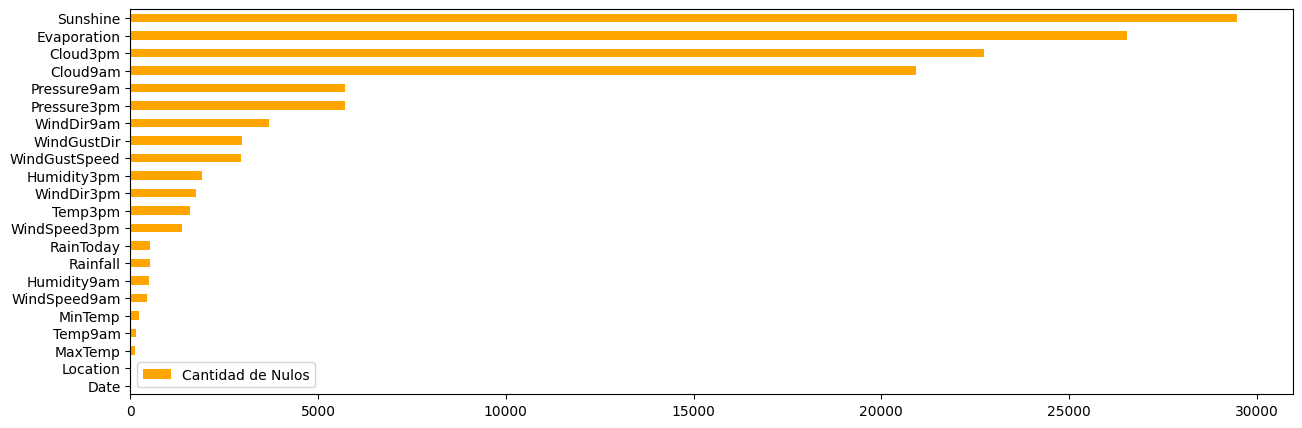

In [13]:
# Graficamos la distribución de valores nulos en cada variable
atributos_nulos = (df.isnull()).sum(axis=0)
atributos_nulos = pd.DataFrame(atributos_nulos, columns=['Cantidad de Nulos'])
atributos_nulos = atributos_nulos.sort_values(by=['Cantidad de Nulos'], ascending=True)
atributos_nulos.drop(['CLASE'], inplace = True)
atributos_nulos.plot(kind='barh', figsize=(15,5), color='orange', grid=False)

### 1.b) Análisis de Outliers

Analizamos los valores outliers de cada variable y determinamos si queremos/debemos imputarlos o no.

/tmp/ipython-input-2851271142.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=c, data=df, orient = 'h', palette="Set2")
/tmp/ipython-input-2851271142.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=c, data=df, orient = 'h', palette="Set2")
/tmp/ipython-input-2851271142.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=c, data=df, orient = 'h', palette="Set2")
/tmp/ipython-input-2851271142.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `

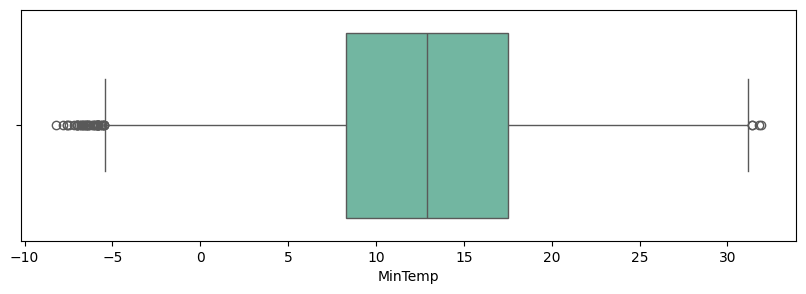

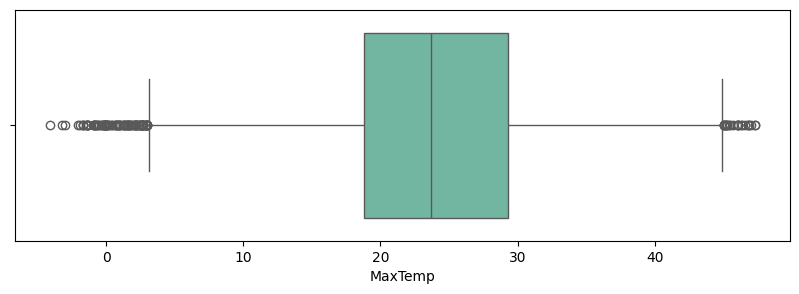

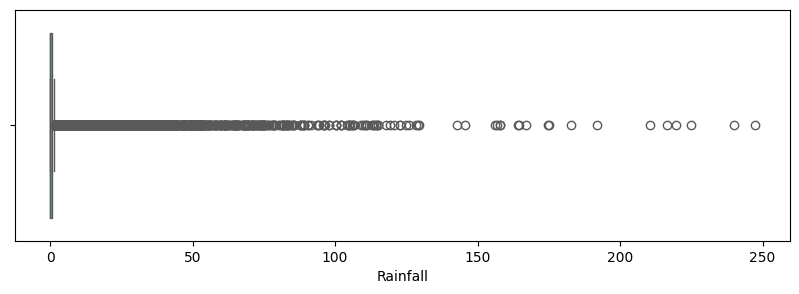

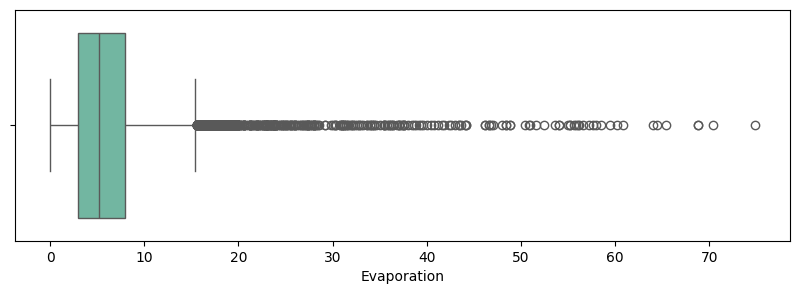

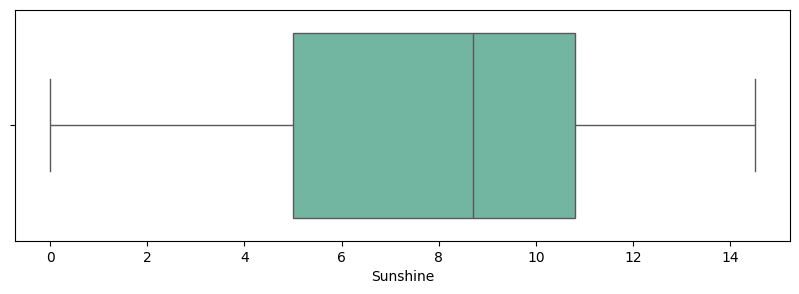

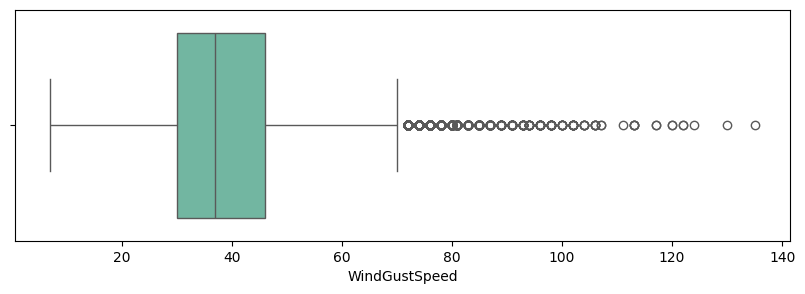

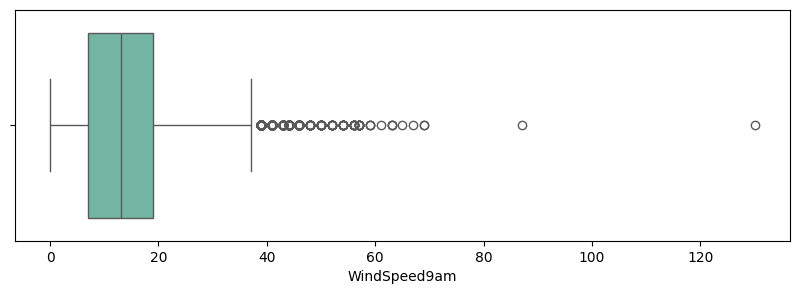

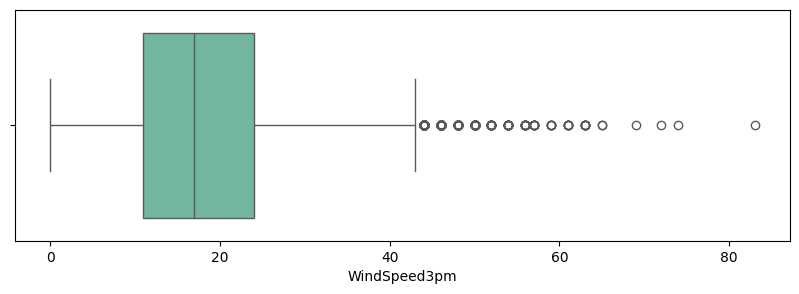

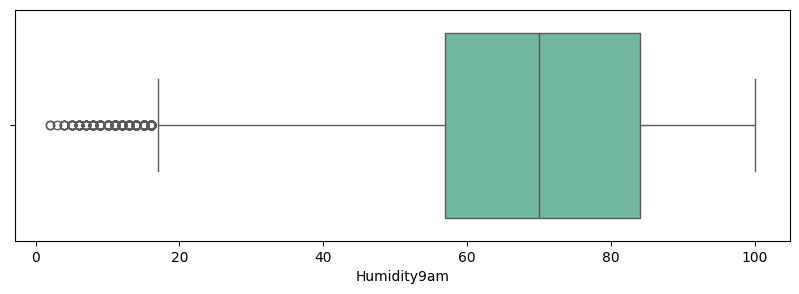

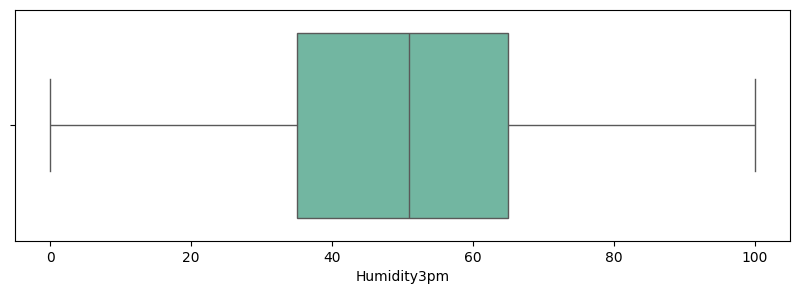

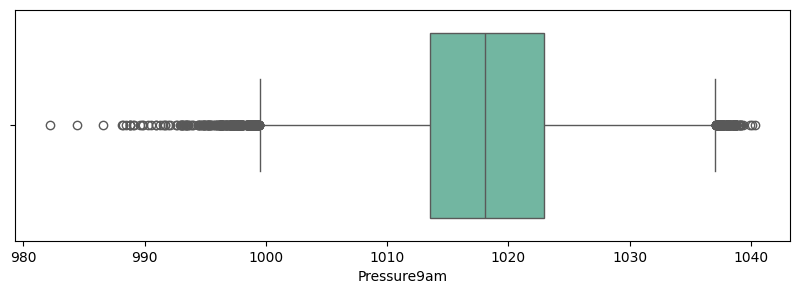

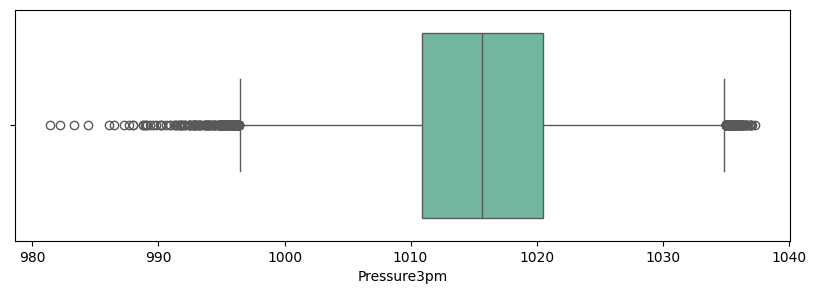

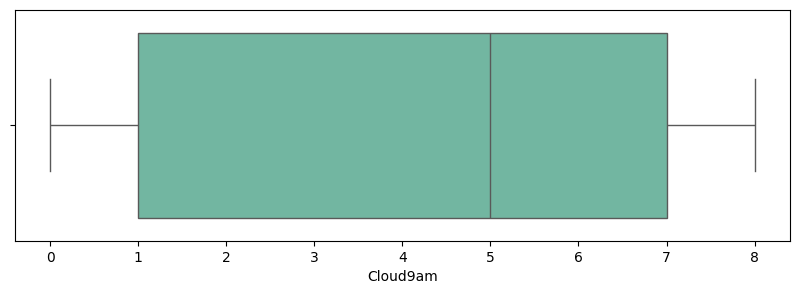

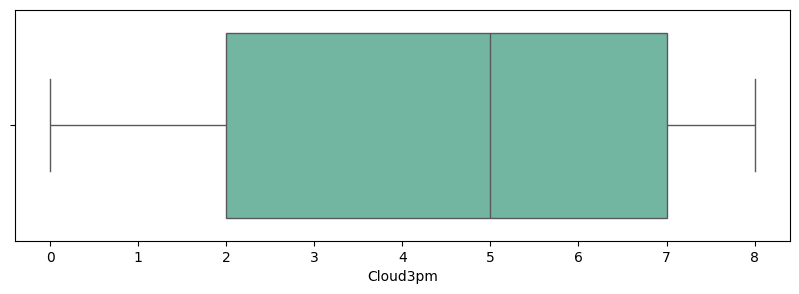

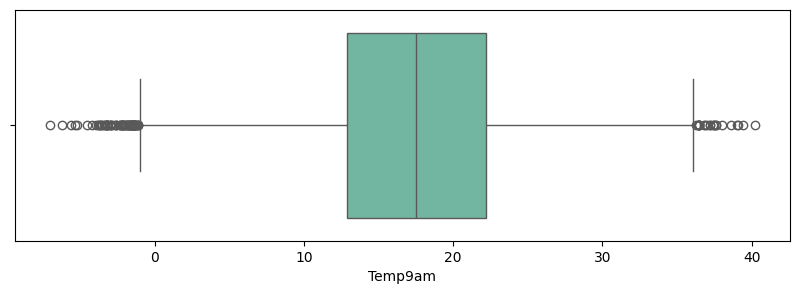

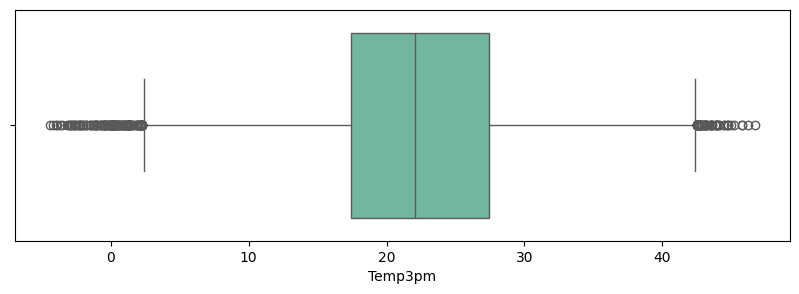

In [14]:
# Creamos un gráfico boxplot para analizar las variables
for c in df.columns:
  if("float" in str(df.dtypes[c]) or "int" in str(df.dtypes[c])):
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=c, data=df, orient = 'h', palette="Set2")

#### **Imputación de Outliers**

**Consignas**
- ¿En qué variables realizaría imputación de outliers y qué criterio aplicaría (1,5 desvios, 2 desvios, 3 desvios...) ?

- ¿Alguna variable requiere especial atención? ¿Cúal/es?

Cabe resaltar que la imputación debe realizarse en la fase de **Preparación de Datos**.

### 1.c) Análisis de Correlación de Variables Numéricas

Una matriz de correlación permite estudiar la relación lineal o comportamiento que puede existir entre dos o más variables.

  - Correlación positiva: ocurre cuando una variable aumenta y la otra también.
  - Correlación negativa: es cuando una variable aumenta y la otra disminuye.
  - Sin correlación: no hay una relación aparente entre las variables.

In [40]:
df_types = df.dtypes.reset_index()
ordinals_cols = list(df_types[(df_types[0]=="float64") | (df_types[0]=="int64")]["index"])

In [44]:
# Creamos una variable numérica CLASE_NUM a partir de nuestra variable objetivo CLASE.
# La misma tendrá un valor 1 cuando llovió el dia siguiente y un valor 0 en caso contrario
# Esta variable se usará para calcular la correlacion lineal entre las variables númericas y la variable objetivo.
df['CLASE_NUM'] = list(map(lambda clase: 1 if (clase == 'Yes') else 0, df['CLASE']))

# Calculamos la matriz de correlacion entre todas las variables del dataset.
df[ordinals_cols].corr()

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
MinTemp        1.000000  0.738373  0.105559     0.428900  0.101644   
MaxTemp        0.738373  1.000000 -0.071852     0.558016  0.493013   
Rainfall       0.105559 -0.071852  1.000000    -0.054354 -0.225193   
Evaporation    0.428900  0.558016 -0.054354     1.000000  0.371226   
Sunshine       0.101644  0.493013 -0.225193     0.371226  1.000000   
WindGustSpeed  0.202623  0.105191  0.135290     0.209591 -0.023237   
WindSpeed9am   0.187120  0.041079  0.081410     0.202771  0.023350   
WindSpeed3pm   0.190265  0.064825  0.062742     0.129366  0.070957   
Humidity9am   -0.251096 -0.523580  0.215373    -0.481143 -0.479458   
Humidity3pm   -0.018834 -0.534087  0.251283    -0.393485 -0.618801   
Pressure9am   -0.524569 -0.414328 -0.160434    -0.280346  0.013332   
Pressure3pm   -0.536143 -0.508946 -0.122957    -0.303489 -0.056732   
Cloud9am       0.019209 -0.318372  0.186223    -0.196484 -0.669132   
Cloud3pm      -0.015576 -0.291908  0.165053    -0.183518 -0.705603   
Temp9am        0.907265  0.884483  0.015240     0.507469  0.315425   
Temp3pm        0.712873  0.985374 -0.079792     0.546003  0.511629   
CLASE_NUM      0.103244 -0.132224  0.229044    -0.111030 -0.435016   

               WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
MinTemp             0.202623      0.187120      0.190265    -0.251096   
MaxTemp             0.105191      0.041079      0.064825    -0.523580   
Rainfall            0.135290      0.081410      0.062742     0.215373   
Evaporation         0.209591      0.202771      0.129366    -0.481143   
Sunshine           -0.023237      0.023350      0.070957    -0.479458   
WindGustSpeed       1.000000      0.583029      0.669390    -0.207420   
WindSpeed9am        0.583029      1.000000      0.500641    -0.266035   
WindSpeed3pm        0.669390      0.500641      1.000000    -0.128160   
Humidity9am        -0.207420     -0.266035     -0.128160     1.000000   
Humidity3pm        -0.036900     -0.046943      0.025612     0.678228   
Pressure9am        -0.437522     -0.195050     -0.276093     0.153033   
Pressure3pm        -0.391660     -0.146054     -0.230539     0.202506   
Cloud9am            0.049700      0.002459      0.036597     0.449304   
Cloud3pm            0.080833      0.026094      0.003615     0.354524   
Temp9am             0.176864      0.144114      0.177821    -0.481917   
Temp3pm             0.069675      0.034144      0.045334    -0.523972   
CLASE_NUM           0.229023      0.069955      0.082232     0.248336   

               Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
MinTemp          -0.018834    -0.524569    -0.536143  0.019209 -0.015576   
MaxTemp          -0.534087    -0.414328    -0.508946 -0.318372 -0.291908   
Rainfall          0.251283    -0.160434    -0.122957  0.186223  0.165053   
Evaporation      -0.393485    -0.280346    -0.303489 -0.196484 -0.183518   
Sunshine         -0.618801     0.013332    -0.056732 -0.669132 -0.705603   
WindGustSpeed    -0.036900    -0.437522    -0.391660  0.049700  0.080833   
WindSpeed9am     -0.046943    -0.195050    -0.146054  0.002459  0.026094   
WindSpeed3pm      0.025612    -0.276093    -0.230539  0.036597  0.003615   
Humidity9am       0.678228     0.153033     0.202506  0.449304  0.354524   
Humidity3pm       1.000000     0.004192     0.085910  0.497826  0.507588   
Pressure9am       0.004192     1.000000     0.962969 -0.091704 -0.113203   
Pressure3pm       0.085910     0.962969     1.000000 -0.019493 -0.048733   
Cloud9am          0.497826    -0.091704    -0.019493  1.000000  0.594038   
Cloud3pm          0.507588    -0.113203    -0.048733  0.594038  1.000000   
Temp9am          -0.241281    -0.497780    -0.544396 -0.179945 -0.150690   
Temp3pm          -0.578469    -0.370691    -0.472662 -0.326434 -0.327912   
CLASE_NUM         0.431523    -0.234263    -0.212258  0.296028  0.356734   

                Temp9am   Temp3pm  CLASE_NUM  
MinTemp        0.907265 

In [45]:
# Seleccionamos sólo la correlación de la variable objetivo numérica CLASE_NUM.
dfd = df[ordinals_cols].corr()[["CLASE_NUM"]]*100
dfd

CLASE_NUM
MinTemp         10.324360
MaxTemp        -13.222414
Rainfall        22.904410
Evaporation    -11.102992
Sunshine       -43.501625
WindGustSpeed   22.902342
WindSpeed9am     6.995512
WindSpeed3pm     8.223173
Humidity9am     24.833645
Humidity3pm     43.152266
Pressure9am    -23.426327
Pressure3pm    -21.225760
Cloud9am        29.602768
Cloud3pm        35.673438
Temp9am         -0.194326
Temp3pm        -16.792537
CLASE_NUM      100.000000

In [46]:
# Borramos la correlación de la variable objetivo numérica consigo misma.
dfd = dfd.drop("CLASE_NUM", axis=0)   # CLASE_NUM = 100

# Ordenamos las variables de forma decreciente por el valor de correlación positiva con la variable objetivo.
dfd = dfd.sort_values(["CLASE_NUM"], ascending=False)
dfd

CLASE_NUM
Humidity3pm    43.152266
Cloud3pm       35.673438
Cloud9am       29.602768
Humidity9am    24.833645
Rainfall       22.904410
WindGustSpeed  22.902342
MinTemp        10.324360
WindSpeed3pm    8.223173
WindSpeed9am    6.995512
Temp9am        -0.194326
Evaporation   -11.102992
MaxTemp       -13.222414
Temp3pm       -16.792537
Pressure3pm   -21.225760
Pressure9am   -23.426327
Sunshine      -43.501625

#### **Correlación de Variables**

**Consignas**
- ¿Qué variables son interesantes para la predicción a realizar?

- ¿Qué acciones realizaría con ellas para aumentar el poder predictivo del modelo a generar?

Cabe resaltar que cualquier actividad a realizar sobre el set de datos, debe realizarse en la fase de **Preparación de Datos**.

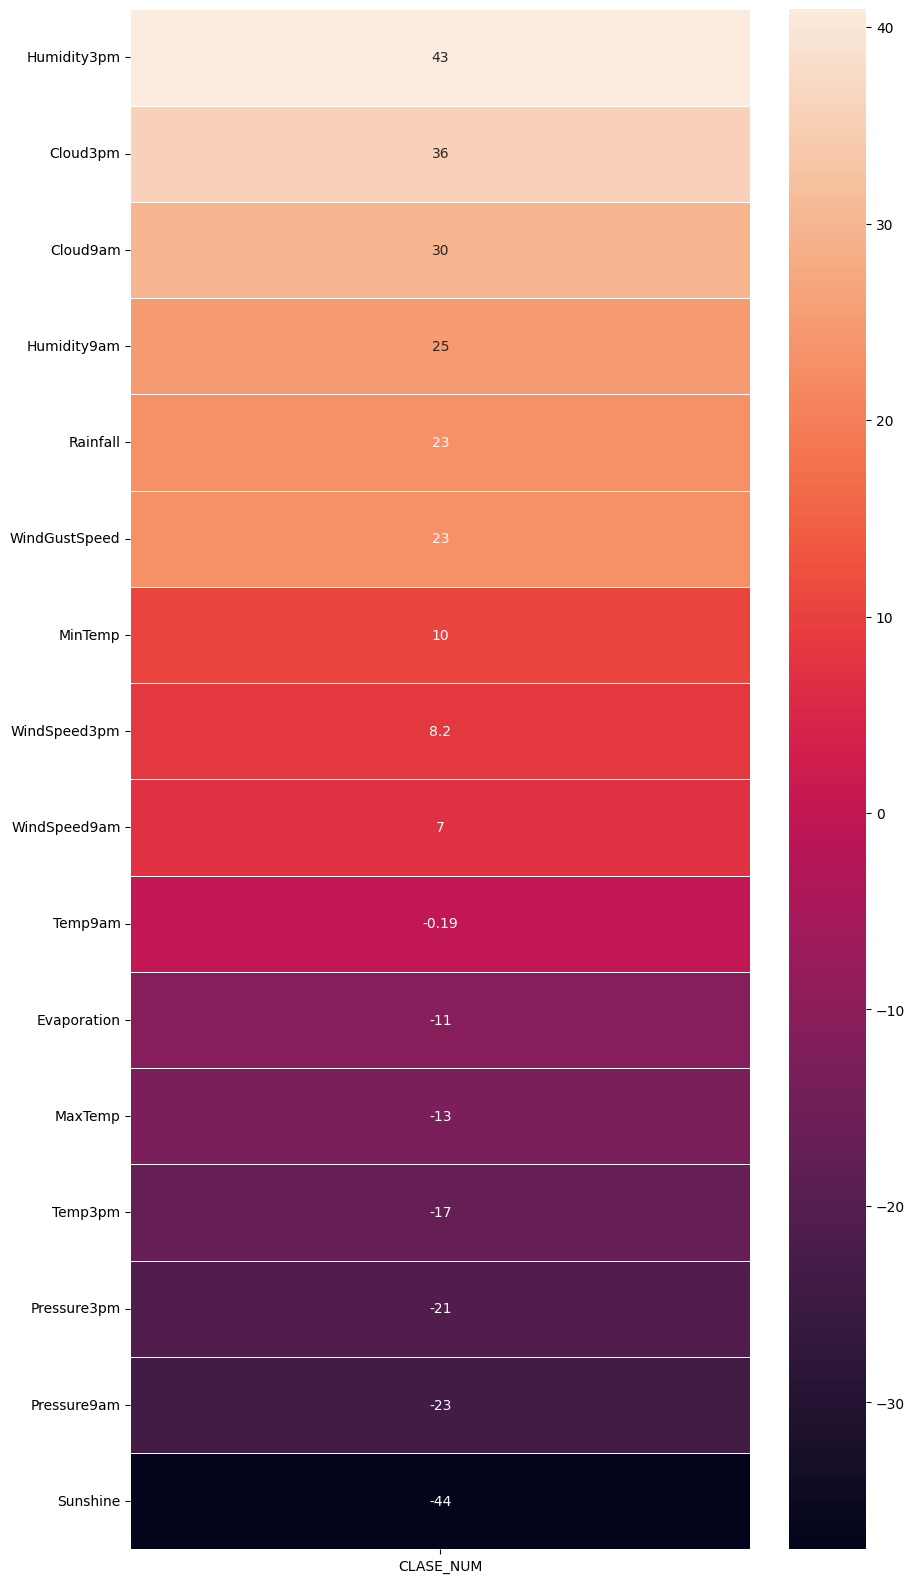

In [47]:
# Graficamos el mapa de calor.
plt.figure(figsize=(10, 20))
sns.heatmap(dfd, robust=True, linewidths=.5, annot=True, )

df.drop(["CLASE_NUM"], axis=1, inplace=True)

### 1.d) Análisis del nivel de humedad

Vamos a analizar ahora cómo se relaciona el nivel de humedad (Humidity3pm) con la probabilidad de que mañana llueva.

/tmp/ipython-input-2193543237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s=sns.boxplot(x="CLASE", y="Humidity3pm", data=df,  palette="cubehelix")


[]

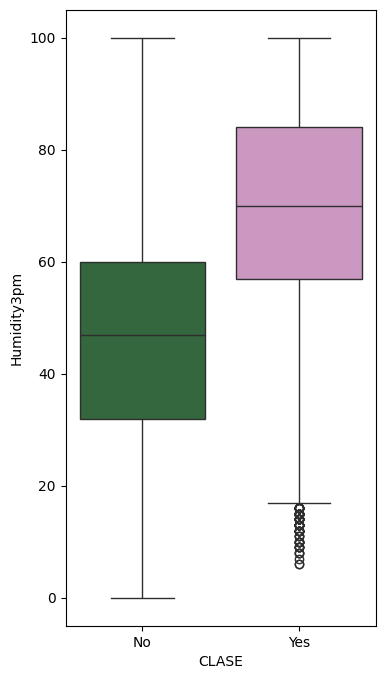

In [48]:
# Creamos un gráfico boxplot para analizar el nivel de humedad respecto a la CLASE
plt.figure(figsize=(4, 8))
s=sns.boxplot(x="CLASE", y="Humidity3pm", data=df,  palette="cubehelix")
s.plot()

#### **Distribución de variables**
- **Consigna**: ¿Se observa alguna relación respecto a la humedad entre los días que llovió y los que no?

Realizar el mismo análisis para todas las variables númericas y analizar su relación con el target de predicción.


### 1.e) Análisis de las variables categóricas de forma visual
En este punto vemos cómo comparar la distribución de una variable categórica (por ejemplo RainToday) vs nuestro target de predicción. Este mismo análisis debería realizarse para todas las variables categóricas del set de datos.

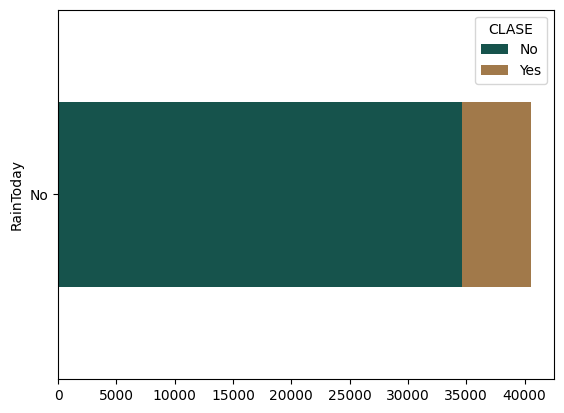

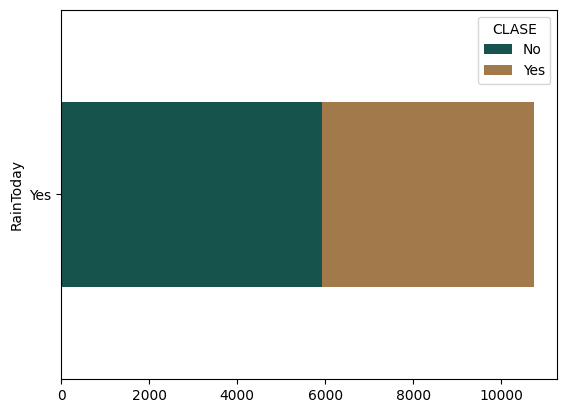

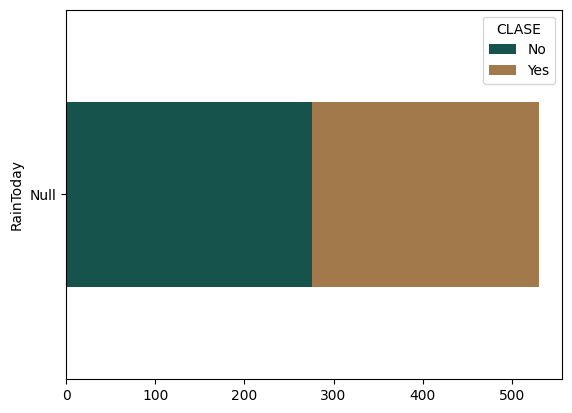

In [49]:
# Distribución de la probabilidad de que llueva mañana, dado que llovió hoy (variable RainToday)

# Copiamos el dataset para agregar una 3ra categoría para los nulos
df2 = copy.copy(df)
df2["RainToday"] = df2["RainToday"].fillna('Null')

ct = pd.crosstab(df2.RainToday, df.CLASE, margins=False)   # armamos una tabla cruzada
for c in df2.RainToday.unique():
  ct.loc[[c]].plot.barh(stacked=True, color=sns.color_palette("cubehelix", len(df2.RainToday.unique())))  # loc trabaja en las etiquetas del índice para armar un gráfico de barras)

# Borramos el dataset creado para imputar los nulls en la 3ra categoria
del df2

plt.show()

#### **Correlación en Variables Categóricas**
**Consignas**
- ¿Se observa alguna relación entre la probabilidad de que llueva mañana en función de si hoy llovió?

- ¿Qué puede decir sobre la categoría Null? ¿Que acciones tomaría?


Cabe resaltar que cualquier actividad a realizar sobre el set de datos, debe realizarse en la fase de **Preparación de Datos**.

## 2. Preparación de datos

Una vez cargados los datos y analizados, se deben preparar para ser procesados. Los 3 pasos generales que se deben seguir son:

1. Tratamiento de outliers
2. Feature engineering
3. Tratamiento de missing values (o valores nulos)

Los pasos detallados de la fase, son:

- Leer los datos con Pandas.
- Comprobar si hay valores nulos y crear todas las variables nuevas.
- Encodear todos los atributos categóricos como booleanos usando `pd.get_dummies`
- Encodear las etiquetas usando `LabelEncoder`
- Construir una variable Y que contenga la variable objetivo a predecir y una vector X que contenga todo el resto de variables a usar en la predicción.
- Dividir el dataset completo en training y testing
- Dividir X e y con train_test_split así:
        train_test_split(X, y, test_size=0.3, random_state=42)

Para el paso de feature engineering se podría usar la libreria "featuretools" la documentación se puede encontrar en:
https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html

Con esta librería se generarán automáticamente las combinaciones "primitivas" posibles entre las variables que tenemos. Como ejemplo, la división de una variable con otra, el máximo, minimo, mediana, etc.

Vamos a crear una función llamada **preparacion_de_datos(dataset)** que incluirá todas las tareas de preparación de datos necesarias para construir nuestro modelo predictivo. Esta función la vamos a utilizar tanto para el dataset de entrenamiento como para el de prueba.

****A partir de este momento, la variable CLASE (objetivo) deja de ser una etiqueta para convertirse en una variable numérica, con valores: 0 (NO LLUEVE) 1 (LLUEVE)****

In [50]:
# FUNCION preparacion_de_datos (:parametros)
#   df_e            => Dataset de entrada a modificar
#   imputar_ouliers => Flag que indica si se deben imputar outliers o no
#   imputar_nulos   => Flag que indica si se deben imputar nulos o no

def preparacion_de_datos(df_e, imputar_ouliers, imputar_nulos):
  # Comenzamos haciendo una copia del dataset que la función recibe como parámetro de entrada
  df_s = copy.copy(df_e)

  # Quitamos el atributo Date, aunque se podría jugar con esta variable
  df_s  = df_s.drop(['Date'], axis=1)

  # (*1) ---- IMPUTACIÓN DE OUTLIERS ----

  # En este punto se deben imputar los valores outliers, sólo si se indicó por parámetro(imputar_outliers)
  if imputar_ouliers:
    print("TODO: Imputación de outliers.")

    # Como ejemplo imputamos la variable "Evaporation" que vimos necesitaba imputación sólo de outliers superiores

    # Primero definimos una función para calcular la media, con los parámetros:
    ## dff -> Dataframe a usar
    ## c   -> Columna a imputar
    ## min -> Límite inferior, si no aplica no se envía.
    ## max -> Límite superior, si no aplica no se envía.

    def calcular_media(dff, c, min=None, max=None):
      # Seteamos el mínimo y máximo, si viene por parámetro. Si no fueron informados, tomamos el actual del set de datos.
      minimo = dff[c].min() if min==None else min
      maximo = dff[c].max() if max==None else max

      # Filtramos los registros dentro del rango
      dff2 = dff[(dff[c]>=minimo) & (dff[c]<=maximo)]

      # Devolvemos la media
      return dff2[c].mean()

    # Calculamos el límite superior y la media sin los outliers para luego imputar.
    # Lo hacemos por fuera para no ejecutar el cálculo una vez por cada registro
    outlier_superior = df_s['Evaporation'].mean() + 1.5*df_s['Evaporation'].std()
    media_sin_outliers = calcular_media(df_s, 'Evaporation', max=outlier_superior)

    # Imputamos por la media los outliers superiores
    df_s['Evaporation'] = df_s.apply(lambda x: media_sin_outliers if x['Evaporation']>outlier_superior else x['Evaporation'], axis=1)


  # (*2) ---- FEATURE ENGINEERING ----

  # Cada unx puede crear los atributos que considere necesario (y mejoren la predicción)
  print("TODO: Creación de nuevas variables.")

  # Dejamos un ejemplo de como crear un atributo, hay que dar especial atención a los atributos
  # que son del tipo cociente, ya que agregan información que los métodos de clasificación
  # en general no pueden obtener:

  ## 1) Cociente entre la nubosidad a las 9am y a las 3pm para ver la variación de nubosidad
  ## Las variables "Cocientes" las vamos a indicar con "c_")
  df_s['c_Cloud_3vs9'] = list(map(lambda cloud9, cloud3:
                                      round( ( (cloud3 or 0)/cloud9 if ( (cloud9 or 0) != 0 ) else 0 ), 2) ,
                                      df_s['Cloud9am'],
                                      df_s['Cloud3pm']))

  ## 1) Cociente entre la humedad a las 9am y a las 3pm para ver la variación de nubosidad
  ## Las variables "Cocientes" las vamos a indicar con "c_")
  df_s['c_Humidity_3vs9'] = list(map(lambda Humidity9, Humidity3:
                                      round( ( (Humidity3 or 0)/Humidity9 if ( (Humidity9 or 0) != 0 ) else 0 ), 2) ,
                                      df_s['Humidity9am'],
                                      df_s['Humidity3pm']))


  # (*3) ---- TRATAMIENTO DE VALORES NULOS ----

  # Veamos si tenemos valores nulos o infinitos. Como ejemplo, podemos optar por setear el valor 0 por defecto.
  if imputar_nulos:
    print("TODO: Imputación de valores nulos.")

    # Posible imputación de nulos
    # Imputamos por la media a los nulos de las cuatro variables con muchisimos nulos
    #for c in ['Evaporation','Sunshine','Cloud9am','Cloud3pm']:
      #media = calcular_media(df_s, c)
      #df_s[c] = df_s.apply(lambda x: media if x[c] is None else x[c], axis=1)

    # A la variable RainToday, le relleno los nulos con una nueva categoria Null
    df_s["RainToday"] = df_s["RainToday"].fillna('Null')

    # Al resto los fuerzo 0
    df_s[df_s==np.inf]=np.nan
    df_s.fillna(0, inplace=True)


  # Tratamiento especial variables categóricas con alta dimensionalidad, ej:"Location"
  # Creamos un índice de humedad de las 3pm por location
  df_s['Location_Humidity3pm'] = df_s.groupby('Location')['Humidity3pm'].transform('mean')
  df_s['c_Location_Humidity3pm'] = list(map(lambda humidity, location_himdity:
                                            round( ( (humidity or 0)/location_himdity if ( (location_himdity or 0) != 0 ) else 0 ), 2) ,
                                            df_s['Humidity3pm'],
                                            df_s['Location_Humidity3pm']))

  # Creamos un índice de %días que llovió historicamente por location
  # En este caso lo estamos haciendo transversal, lo ideal sería hacerlo relativo a las fechas previas a la acual.
  df_s['RainTodayN'] = df_s.apply(lambda x: 1 if x['RainToday']=='Yes' else 0, axis=1)
  df_s['idd'] = 1
  df_s['Location_RainTodayN_Yes'] = df_s.groupby('Location')['RainTodayN'].transform('sum')
  df_s['Location_RainTodayN_Tot'] = df_s.groupby('Location')['idd'].transform('sum')
  df_s['c_Location_RainToday_Yes'] = list(map(lambda rain_today, total:
                                            round( ( (rain_today or 0)/total if ( (total or 0) != 0 ) else 0 ), 3) ,
                                            df_s['Location_RainTodayN_Yes'],
                                            df_s['Location_RainTodayN_Tot']))

  # Borramos las variables que ya no nos sirven
  df_s.drop(["Location", "Location_Humidity3pm", "RainTodayN","idd","Location_RainTodayN_Yes","Location_RainTodayN_Tot"], axis=1, inplace=True)

  # Convertimos la variable clase en un numérico con 0 o 1
  df_s['CLASE'] = list(map(lambda clase: 1 if (clase == 'Yes') else 0, df_s['CLASE']))

  return df_s

In [51]:
# Ejecutamos la función de preparacion de datos.
# Indicando que si queremos imputar ouliers y si queremos imputar nulos
# Este el primer paso que debemos realizar para tener todas las variables a utilizar.
df = preparacion_de_datos(df, True, True)

df.head()

TODO: Imputación de outliers.
TODO: Creación de nuevas variables.
TODO: Imputación de valores nulos.


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0     12.0     27.4       0.0          0.0       0.0         WNW   
1     16.7     27.7       0.0          0.0       0.0           W   
2     18.9     30.6       0.2          0.0       0.0         WSW   
3     13.1     25.6       0.0          0.0       0.0           W   
4      8.4     29.4       0.0          0.0       0.0         WNW   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Cloud9am  Cloud3pm  \
0           43.0        SSE        ENE          11.0  ...       0.0       1.0   
1           31.0        WNW        WNW           6.0  ...       1.0       1.0   
2           44.0        ENE          W           6.0  ...       8.0       8.0   
3           46.0        WSW          W          24.0  ...       0.0       4.0   
4           65.0         SE         NW           6.0  ...       0.0       1.0   

   Temp9am  Temp3pm  RainToday  CLASE  c_Cloud_3vs9  c_Humidity_3vs9  \
0     20.3     25.9         No      0           0.0             0.68   
1     22.3     26.4         No      0           1.0             0.36   
2     22.3     27.5         No      0           1.0             0.80   
3     16.8     24.2         No      0           0.0             0.61   
4     18.7     28.9         No      0           0.0             0.48   

   c_Location_Humidity3pm c_Location_RainToday_Yes  
0                    0.82                    0.182  
1                    0.48                    0.182  
2                    0.69                    0.182  
3                    0.61                    0.182  
4                    0.52                    0.182  

[5 rows x 25 columns]

In [52]:
print(df.shape)

(51785, 25)


In [53]:
# Dejamos en el dataset de entrenamiento todas las variables, excepto la CLASE.

# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo).

X  = pd.get_dummies(df.drop(['CLASE'], axis=1))
atributos = X.columns

# Encodeamos las etiquetas usando LabelEncoder
# Convertimos la variable objetivo en una variable booleana de valores 0 o 1 para simplificar los cálculos

le = LabelEncoder()
y = le.fit_transform(df['CLASE'])


# Dividimos el dataset en entrenamiento y prueba (70% para training y 30% para testing)
# Dividimos X e y con la funcion train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

print(X_train.shape)
X_train.head(5)

(36249, 74)


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
5960      19.6     32.9       0.0          0.0       0.0            0.0   
30182     21.5     29.4       0.0          8.4       3.6           28.0   
34059     11.0     15.9       2.8          4.2       0.0           30.0   
3853      17.1     24.1      13.0          0.0       0.0           24.0   
50719     19.4     31.7       0.0          2.6       0.0           41.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
5960            9.0           0.0         43.0          0.0  ...   
30182           7.0          13.0         58.0         61.0  ...   
34059           9.0          11.0         70.0         41.0  ...   
3853           13.0           9.0         81.0         95.0  ...   
50719           9.0          20.0         77.0          0.0  ...   

       WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  \
5960           False           False           False          False   
30182          False           False           False          False   
34059          False           False           False          False   
3853           False           False           False          False   
50719          False           False           False          False   

       WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  RainToday_No  \
5960          False           False           False          True   
30182         False           False           False          True   
34059         False           False           False         False   
3853          False           False            True         False   
50719         False           False           False          True   

       RainToday_Null  RainToday_Yes  
5960            False          False  
30182           False          False  
34059           False           True  
3853            False           True  
50719           False          False  

[5 rows x 74 columns]

#### **Preparación de Datos**
**Consignas**
- ¿Se observa algo objetable en el set de datos generado?

- ¿Hay alguna variable que requiera un tratamiento adicional?


Cabe resaltar que cualquier actividad a realizar sobre el set de datos, debe realizarse en la fase de **Preparación de Datos**.

## 3. Construcción del modelo predictivo sin optimizacion de hiperparámetros

### 3.a) Modelo inicial

Vamos a construir un árbol de clasificación inicial usando el dataset. Los pasos que realizaremos son:

- Ajustar un árbol de clasificación con `max_depth=3`
- Visualizar el árbol usando graphviz
- Calcular la importancia de los atributos
- Calcular y mostrar la matriz de confusión
- Sacar la restricción de `max_depth=3` y ver si la clasificación mejora

In [54]:
# Ajustamos un árbol de clasificación con max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

### 3.b) Interpretación de resultados
- Visualizaremos el árbol de decision generado junto con las condiciones de split y los nodos resultantes.
- Analizaremos cómo contribuyeron las variables usadas en la predicción.
- Calcularemos el error de entrenamiento y de testeo del modelo generado.


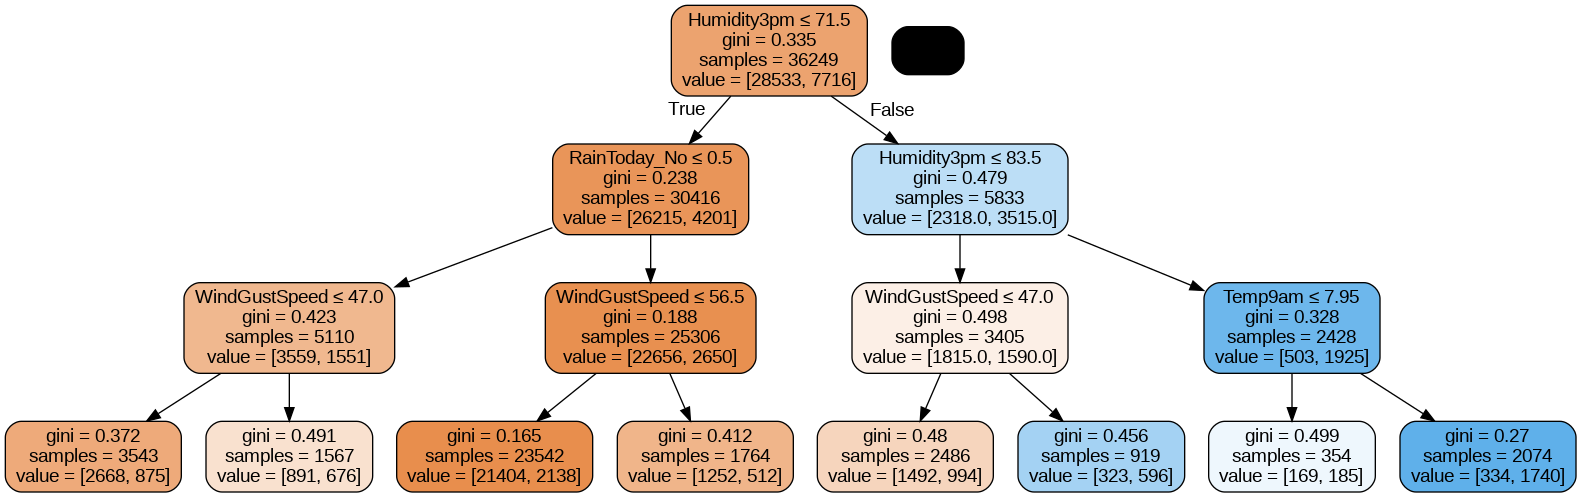

In [55]:
# Visualizamos el árbol de decisión usando graphviz
dot_data = export_graphviz(treeclf, out_file=None,
                feature_names=atributos,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### 3.b.i) Lectura del árbol de decisión generado

#### **Interpretación de Resultados**
- **Consigna**: Indicar, por lo menos, dos reglas de relevancia donde la predicción sea positiva (Mañana Llueve).

-	Humidity3pm > 71.5	->	Humidity3pm > 83.5	-> Temp9am > 7.95		=> P('LLUEVE') = 1740 / 2074 = 83.9%

-	Humidity3pm > 71.5	->	Humidity3pm <= 83.5	-> Windgustspeed > 47.0	=> P('LLUEVE') = 596  /  919 = 64.85%

### 3.b.ii) Curva ROC

La curva ROC nos permite visualizar cómo se distribuyen los casos positivos y negativos dentro de nuestro modelo.

En resumen, nos indica qué % de casos positivos (clase target) vamos a captar si tomamos X % de negativos, esto da una clara idea del poder predictivo del algoritmo. Este valor se resume en la métrica AUC (Area Under Curve), la cual indica qué tan "rápido" crece la curva (incluye mayor % de positivos) conforme avanza la cantidad de negativos.

Los **mejores algoritmos**, son aquellos que tienen curvas que **comienzan con pendientes muy grandes y crecen verticalmente muy rápido**, ya que esto indica que captan mayor cantidad de positivos para la misma cantidad de negativos.


AUC - Area Under the Curve - Área Bajo la Curva: 0.7671578517949118


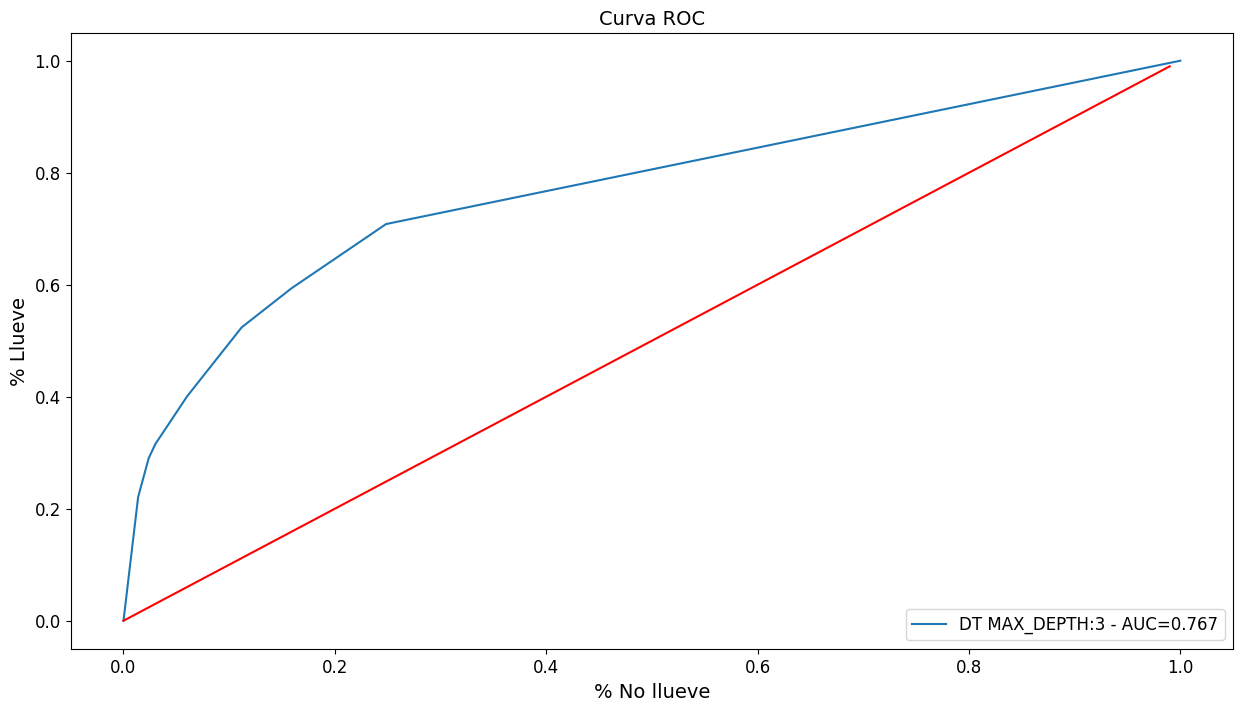

In [56]:
plt.figure(figsize=(15, 8))

y_pred_proba = treeclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC - Area Under the Curve - Área Bajo la Curva: {}".format(auc))

# Graficamos la curva roc del arbol
plt.plot(fpr,tpr,label="DT MAX_DEPTH:3 - AUC="+str(round(auc,3)))
plt.xlabel('% No llueve', fontsize=14)
plt.ylabel('% Llueve', fontsize=14)
plt.legend(loc=4, fontsize=12)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="red")

plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Cuando se prueban distintos algoritmos, lo ideal es dibujar todas las curvas ROC en el mismo gráfico y comparar cómo se distancian unas de otras. En general, no existen grandes diferencias, pero son las pequeñas diferencias las que generan mayores ganancias.

Para comparar el poder predictivo de los algoritmos también se utiliza la métrica AUC (Área Bajo la Curva) pero esta métrica es genérica de la predicción completa y no aporta distintas visiones, depende del corte que querramos aplicar para saber qué efectividad tiene.


### 3.b.iii) Importancia de las variables

- La primera columna es el nombre de la variable y la segunda indica la importancia relativa a la predicción. Los valores más altos indican que esa variable tiene mayor importancia para "dividir" las distintas clases de la variable objetivo.

- Hay que tener claro que esto no implica una relación positiva, la importancia mide tanto relaciones positivas como las relaciones negativas (inversa).


#### **Importancia de las variables**
- **Consigna**: Indicar las 10 variables con mayor importancia en el modelo y su importancia relativa al mismo.

In [57]:
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                       ascending=False).head(10)

Atributo  importancia
9     Humidity3pm     0.779127
71   RainToday_No     0.108514
5   WindGustSpeed     0.092815
14        Temp9am     0.019544
1         MaxTemp     0.000000
0         MinTemp     0.000000
4        Sunshine     0.000000
6    WindSpeed9am     0.000000
3     Evaporation     0.000000
2        Rainfall     0.000000

### 3.b.iv) Matriz de Confusión del Modelo y Errores de Predicción
Analizando la matriz de confusión, podemos entender en qué casos el modelo acierta en la predicción y cuáles falla. En base a esto, podemos determinar las métricas de evaluación de modelos.

#### **Evaluación de Modelos**
**Consignas**
- Calcular la matríz de confusión.
- Indicar las métricas principales: Exactitud (accuracy) - Error de Predicción - Precisión (precision) - Sensibilidad (recall)


In [58]:
# Calculamos y mostramos la matriz de confusión del modelo
y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)


pred_0  pred_1
0   11972     372
1    2185    1007

In [59]:
# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90     12344
           1       0.73      0.32      0.44      3192

    accuracy                           0.84     15536
   macro avg       0.79      0.64      0.67     15536
weighted avg       0.82      0.84      0.81     15536



## 4. Función de Ganancia y Probabilidad de Corte

Vamos a definir una función de ganancia "teórica" con la probabilidad de corte para este caso práctico.

Esta función de ganancia consiste en **sumar 4 puntos por cada acierto** y **restar 1 punto por cada fallo**, para definir una métrica que podamos usar para la optimización del modelo. Estos puntajes nos definen una **probabilidad de corte** que determinan cuáles de las observaciones serán consideradas como positivas en el hecho que va a llover.

La misma puede calcularse partiendo de la función de ganancia:

- universo_total = dias('LLUEVE') + dias('NO LLUEVE')

- ganancia = **4** * dias('LLUEVE') - **1** * dias('NO LLUEVE')

Si descomponemos el 4 como la resta (5-1), también se podría escribir como:

- ganancia = **5** * dias('LLUEVE') - **1** * dias('LLUEVE') - **1** * dias('NO LLUEVE')

**( * )** Cuando se haga referencia a **dias('LLUEVE')** se refiere a la cantidad (#) de observaciones cuya clase es Yes (llovió al día siguiente), analogamente aplica para **dias('NO LLUEVE')**.
-

Si trabajamos un poco esta función de ganancia, buscando que la ganancia generada sea **mayor a 0**, podemos calcular la **probabilidad de corte**, si tenemos que ganancia > 0, entonces:
- 5 * dias('LLUEVE') - 1 * dias('LLUEVE') - 1 * dias('NO LLUEVE')  **>** 0
- 5 * dias('LLUEVE') - 1 * ( dias('LLUEVE') + dias('NO LLUEVE') )  **>** 0
- 5 * dias('LLUEVE') **>** 1 * ( dias('LLUEVE') + dias('NO LLUEVE') ))

- ( dias('LLUEVE') / ( dias('LLUEVE') + dias('NO LLUEVE') ) ) **>** 1 / 5

- **PROB('LLUEVE') > 0.2**

Esta función nos indica que la **probabilidad de corte es 0.2** aunque uno puede modificar ese valor para mejorar el modelo.

Este es un caso de uso de custom functions para scoring en Grid Searching, ya que por defecto la métrica usada para este tipo de algoritmos es AUC (Area Under the Curve) pero que en la vida real tiene poca aplicación.

In [60]:
prob_corte = float(0.2) # probabilidad de corte calculada

#Definimos la función de ganancia a utilizar para el scoring en la búsqueda:
def funcion_ganancia(clf, X, y_true):
    y_prob_llueve = clf.predict_proba(X)[:, 1]

    ganancia = sum([(4 if y_true[i] > 0 else -1)
                    if y_prob_llueve[i]  > prob_corte
                    else 0
                    for i in range(len(y_prob_llueve))])

    return ganancia

## 5. Construcción del modelo usando GridSearchCV con optimización de hiperparámetros

Las clase **GridSearchCV** se utiliza para automatizar la selección de los parámetros de un modelo, aplicando para ello la técnica de validación cruzada. Partiendo de un modelo y un conjunto de parámetros, GridSearchCV prueba múltiples combinaciones y selecciona los valores de los parámetros que ofrecen mayor rendimiento para un modelo y conjunto de datos.

Los parámetros a optimizar son:

Medida            | Que hace
------------------|-------------
max_depth         | limita la altura del árbol (niveles-2)
max_features      | limita la cantidad de atributos a utilizar en una división
max_leaf_nodes    | limita la cantidad máxima de nodos hoja puede tener el árbol
min_samples_leaf  | cantidad mínima de muestras de una hoja
min_samples_split | cantidad mínima de muestras para dividir un nodo

Cada uno puede definir sus propios rangos de valores para cada parámetro, considerando que cuantos más parámetros se usen, el tiempo de procesamiento crece exponencialmente.

### 5.a) Definición de parámetros

In [61]:
# Definimos los parametros a evaluar:

PARAMETROS = {'max_depth':[3, 10, 12, 15, 50],
              'max_features':[10, 25, 35, 40],
              'max_leaf_nodes':[10, 50, 12, 100, 1000],
              'min_samples_leaf':[20, 50, 100, 500],
              'min_samples_split':[50, 100, 200, 1000]}

k_n_jobs = 2 # numero de iteraciones definidas

# Hacemos la búsqueda con GridSearchCV

model = DecisionTreeClassifier(random_state=1)  # modelo de árbol de decision, podría ser cualquier otro o iterar una lista de modelos para probar y sus parametros
gs = GridSearchCV(model,
                  PARAMETROS,
                  n_jobs=k_n_jobs,
                  scoring=funcion_ganancia,
                  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1), #Cross Validation de 5 capas
                  verbose=1)
gs.fit(X_train, y_train)

# Mostramos los mejores resultados obtenidos

print(gs.best_estimator_)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
DecisionTreeClassifier(max_depth=12, max_features=35, max_leaf_nodes=1000,
                       min_samples_leaf=50, min_samples_split=200,
                       random_state=1)


In [62]:
#print('Puntaje del modelo en CV: {:.2f}'.format(gs.best_score_))
print('Puntaje del modelo en Testing: {:.2f}'.format(funcion_ganancia(gs.best_estimator_, X_test, y_test)))

Puntaje del modelo en Testing: 6808.00


### 5.b) Interpretación de resultados
- Visualizaremos el árbol de decision generado con GridSearchCV  junto con las condiciones de split y los nodos resultantes.
- Analizaremos cómo contribuyeron las variables usadas en la predicción.
- Calcularemos el error de entrenamiento y de testeo del modelo generado.

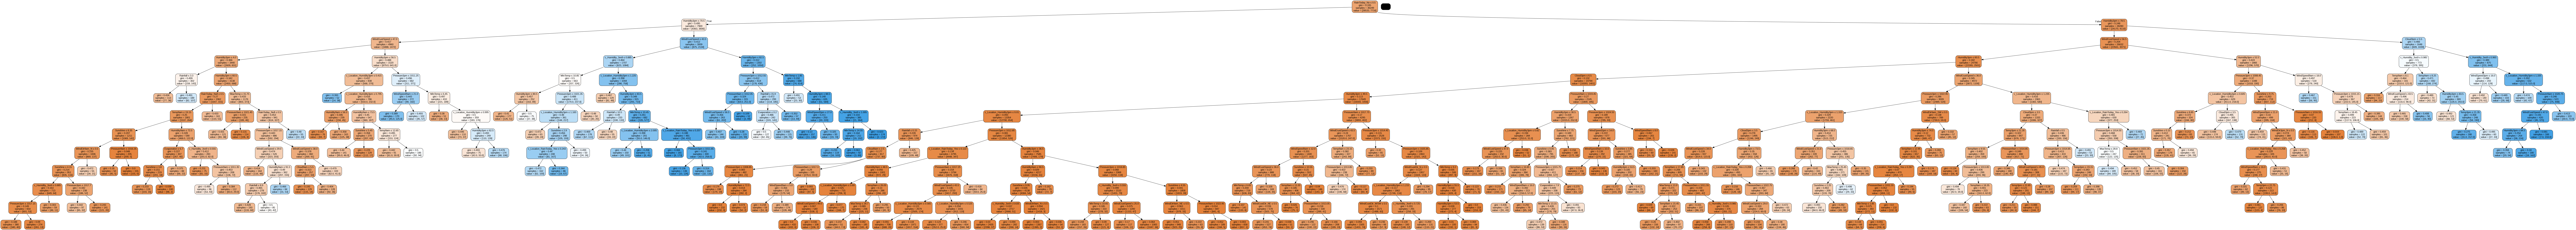

In [63]:
# Visualizamos el mejor árbol de decisión generado usando graphviz
dot_data=export_graphviz(gs.best_estimator_,
                         out_file=None,
                         feature_names=X.columns,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### **Interpretación de Resultados**
- **Consigna**: Indicar, por lo menos, dos reglas relevantes donde la predicción sea positiva (Mañana Llueve).

### 5.b.i) Importancia de las variables

#### **Importancia de las variables**
**Consignas**
- Indicar las 10 variables con mayor importancia en el modelo y su importancia relativa al mismo.

- Analizar qué variables coinciden con el modelo previo y cuáles no.

In [64]:
pd.DataFrame({'Atributo':atributos,
              'importancia':gs.best_estimator_.feature_importances_}).sort_values('importancia',
                                                                       ascending=False).head(15)

Atributo  importancia
9                Humidity3pm     0.428265
71              RainToday_No     0.265128
5              WindGustSpeed     0.078070
18    c_Location_Humidity3pm     0.037195
11               Pressure3pm     0.036830
17           c_Humidity_3vs9     0.024766
13                  Cloud3pm     0.023956
10               Pressure9am     0.015674
4                   Sunshine     0.013500
14                   Temp9am     0.013199
0                    MinTemp     0.010920
2                   Rainfall     0.008736
8                Humidity9am     0.007561
19  c_Location_RainToday_Yes     0.005752
6               WindSpeed9am     0.005613

### 5.b.ii) Curva ROC
Comparamos las curvas ROC y métricas AUC de los distintos árboles generados por GridSearching, para entender qué valores de hiperparámetros mejoran la capacidad predictiva del algoritmo y qué tan grande (o pequeña) es la diferencia entre los árboles.

In [65]:
# Como primer paso, vamos a probar todas las combinaciones de parámetros
# y vamos a guardar los resultados de cada árbol en la lista "resultados"
resultados = []

# Recorremos las combinaciones de parámetros y guardamos el árbol entrenado, parámetros y la predicción
for p in gs.cv_results_['params']:
  try:
    treeclf2 = DecisionTreeClassifier(max_depth= p['max_depth'],
                                      max_features= p['max_features'],
                                      max_leaf_nodes= p['max_leaf_nodes'],
                                      min_samples_split= p['min_samples_split'],
                                      random_state=1)
    treeclf2.fit(X_train, y_train)
    y_pred_proba = treeclf2.predict_proba(X_test)[::,1]

    # Guardamos el árbol, la predicción y los parámetros de cada ejecucion
    resultados.append({"árbol": copy.copy(treeclf2), "prediccion":copy.copy(y_pred_proba), "parámetros":copy.copy(p)})
  except Exception as e:
    print(e)

### Graficamos la curva ROC de cada árbol

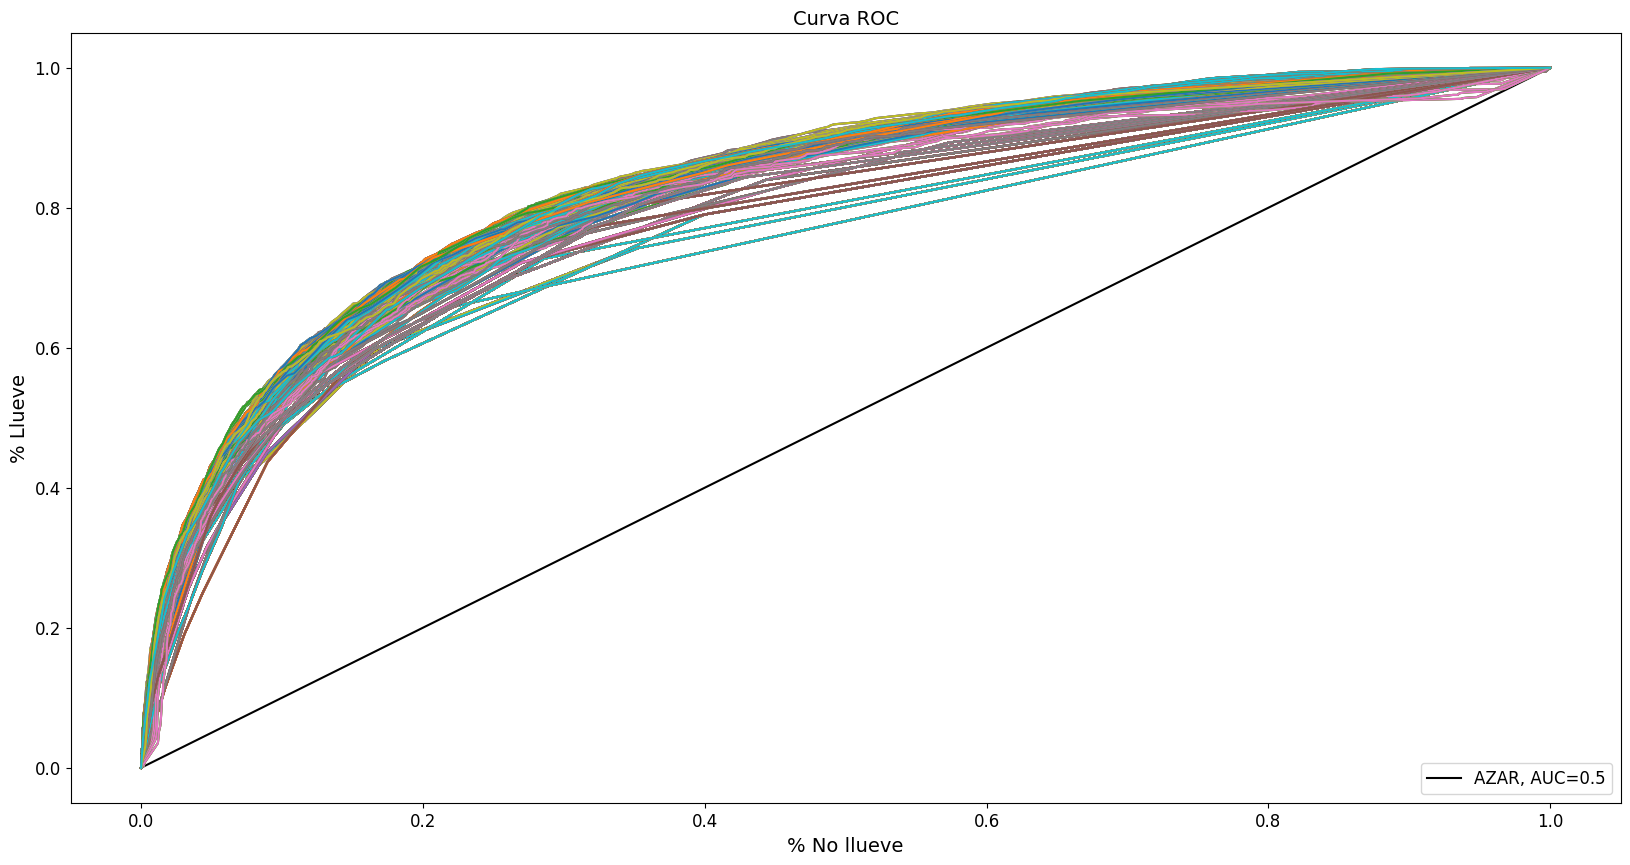

In [66]:
# Graficamos la curva ROC del arbol de cada iteracion
def graficarCurvaRoc(arbol):
  # Calculamos la probabilidad predicha
  y_pred_proba = r['prediccion']

  # Calculamos los valores de la curva ROC para graficar
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

  # Calculamos el Area Bajo la Curva (AUC) y la guardamos
  auc = metrics.roc_auc_score(y_test, y_pred_proba)
  r['auc'] = auc

  # Graficamos
  plt.plot(fpr,tpr) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)

# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% No llueve', fontsize=14)
plt.ylabel('% Llueve', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR, AUC=0.5",color="black")

# Para cada árbol probado (en la variable resultados) graficamos la curva ROC
for r in resultados:
    graficarCurvaRoc(r)

# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

#### **Curva ROC**
**Consignas**
- ¿Cuál es el mejor modelo?
- ¿Qué porcentaje de corte eligirían?


### 5.b.iv) Matriz de Confusión del Modelo y Errores de Predicción

#### **Evaluación de Modelos**
**Consignas**
- Calcular la matríz de confusión.
- Indicar las métricas principales: Exactitud (accuracy) - Error de Predicción - Precisión (precision) - Sensibilidad (recall)


In [67]:
# Calculamos y mostramos la matriz de confusión del modelo
y_pred = gs.best_estimator_.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

predicted_cols = ['pred_'+str(c) for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)


pred_0  pred_1
0   11605     739
1    1714    1478

In [68]:
# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12344
           1       0.67      0.46      0.55      3192

    accuracy                           0.84     15536
   macro avg       0.77      0.70      0.73     15536
weighted avg       0.83      0.84      0.83     15536



## 6. Aplicando el modelo a datos nuevos

Ahora podemos aplicar el modelo generado a los datos nuevos donde no conocemos la clase para predecir el futuro. El set de prueba con los nuevos datos a utilizar es **weather_aus_predecir.csv**.


In [69]:
# Leemos el dataset de aplicacion, para predecir la lluvia en casos que desconocemos el futuro.
dataset_aplicacion='https://raw.githubusercontent.com/unlam-fcdin/UNLaM_FCDIN/master/weather_aus_predecir.csv'
df_apply = pd.read_csv(dataset_aplicacion, sep =',', na_values = '.', parse_dates=["Date"])

# Para estandarizar el análisis, llamaremos variable "CLASE" a la variable target
df_apply['CLASE'] = df_apply['RainTomorrow']
df_apply.drop(["RainTomorrow"], axis=1, inplace=True)

# Siempre el primer paso es ejecutar la función de preparacion de datos que construimos
df_apply = preparacion_de_datos(df_apply, True, True)

# Borramos la CLASE y el campo FOTO_MES, ya que ambos son constantes, en este caso.
df_apply = df_apply.drop(['CLASE'], axis=1)

# Veamos como quedó el dataset
df_apply.head(10)


TODO: Imputación de outliers.
TODO: Creación de nuevas variables.
TODO: Imputación de valores nulos.


MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0      5.2     11.4      11.4          0.0       0.0          NW   
1      7.2     12.5       0.4          0.0       0.0         WSW   
2      7.9     12.7       0.2          0.0       0.0           W   
3      8.2     11.7       0.2          0.0       0.0           E   
4      6.7     10.6       1.0          0.0       0.0         WNW   
5      7.2     15.4       7.6          0.0       0.0         WSW   
6      4.0     16.5       0.0          0.0       0.0          SE   
7      6.5     11.8       0.2          0.0       0.0           S   
8      7.0     15.8       2.0          0.0       0.0          NE   
9      6.2     14.0       0.0          0.0       0.0          NE   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Pressure3pm  \
0           26.0        WSW          W           9.0  ...       1021.4   
1           17.0          0          W           0.0  ...       1026.4   
2           20.0        ENE          W           6.0  ...       1024.7   
3           19.0          0        ENE           0.0  ...       1016.0   
4           19.0          0        SSE           0.0  ...       1008.6   
5           43.0          W        WSW          19.0  ...       1010.4   
6           30.0          0        ESE           0.0  ...       1019.1   
7           17.0          S          E           2.0  ...       1020.8   
8           13.0          0        NNE           0.0  ...       1023.1   
9           28.0          0        NNE           0.0  ...       1018.9   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  c_Cloud_3vs9  \
0       8.0       8.0      7.3     11.1        Yes          1.00   
1       8.0       8.0      9.3     11.6         No          1.00   
2       8.0       7.0      9.7     12.6         No          0.88   
3       8.0       8.0      9.0     11.6         No          1.00   
4       8.0       8.0      7.8      8.9         No          1.00   
5       0.0       2.0     10.6     15.0        Yes          0.00   
6       0.0       5.0      8.3     16.2         No          0.00   
7       8.0       8.0      9.2     11.5         No          1.00   
8       8.0       8.0      9.0     13.9        Yes          1.00   
9       3.0       6.0      9.1     13.4         No          2.00   

   c_Humidity_3vs9  c_Location_Humidity3pm c_Location_RainToday_Yes  
0             0.79                    1.40                    0.266  
1             0.98                    1.58                    0.266  
2             0.82                    1.51                    0.266  
3             0.72                    1.29                    0.266  
4             1.08                    1.82                    0.266  
5             0.75                    1.11                    0.266  
6             0.58                    1.07                    0.266  
7             0.98                    1.73                    0.266  
8             0.76                    1.40                    0.266  
9             0.74                    1.36                    0.266  

[10 rows x 24 columns]

In [70]:
# Encodeamos todos los atributos categóricos como booleanos con la función pd.get_dummies (sin incluir la variable objetivo).
X_apply = pd.get_dummies(df_apply)
atributos = X_apply.columns

# Aplicamos la predicción al nuevo dataset
scores = gs.best_estimator_.predict_proba(X_apply)

# Agregamos al dataset la probabilidad de lluvia predicha con el modelo
df_result = copy.copy(df_apply)
df_result['PROB'] = scores[:,1]

# Veamos como quedó:
df_result.sort_values(by='PROB', ascending=False).head(5)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
6048     11.2     17.4       1.4          0.0       0.0          NW   
6120      6.5     11.8       6.1          3.0       4.2         WNW   
6117     12.2     15.3       2.1          4.3       1.8           W   
4888      5.4     12.4       7.6          1.2       0.0          NW   
8445     25.0     28.9      10.4          3.4       0.9          NW   

      WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Cloud9am  \
6048           65.0        NNW         NW          28.0  ...       8.0   
6120           67.0        WNW        WNW          28.0  ...       2.0   
6117           85.0        WNW          W          28.0  ...       7.0   
4888           83.0          N        WNW          13.0  ...       0.0   
8445           59.0          N          N          20.0  ...       5.0   

      Cloud3pm  Temp9am  Temp3pm  RainToday  c_Cloud_3vs9  c_Humidity_3vs9  \
6048       8.0     15.6     12.6        Yes           1.0             1.15   
6120       0.0      8.5     10.2        Yes           0.0             1.10   
6117       0.0     12.5     10.2        Yes           0.0             1.14   
4888       0.0      7.4      9.0        Yes           0.0             1.03   
8445       7.0     27.9     27.3        Yes           1.4             1.06   

      c_Location_Humidity3pm  c_Location_RainToday_Yes      PROB  
6048                    1.52                     0.420  0.988506  
6120                    1.81                     0.306  0.988506  
6117                    1.81                     0.306  0.988506  
4888                    1.46                     0.413  0.988506  
8445                    1.77                     0.255  0.988506  

[5 rows x 25 columns]

## 7. Entregable Final
Para terminar, vamos a generar un archivo de salida "csv" con los casos donde la medición realizada infiera que el día de mañana va a llover en ese lugar. Esto lo realizamos en función de la probabilidad de corte para filtrar los casos con baja probabilidad.

In [71]:
dataset_entrega='dataset_entrega.csv'

# Entregamos sólo las observaciones donde predecimos que va a llover
df_entregar = df_result[df_result.PROB > prob_corte]
df_entregar.to_csv(path_or_buf=dataset_entrega, sep=",", na_rep='.')
df_entregar.head(10)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0       5.2     11.4      11.4          0.0       0.0          NW   
1       7.2     12.5       0.4          0.0       0.0         WSW   
2       7.9     12.7       0.2          0.0       0.0           W   
4       6.7     10.6       1.0          0.0       0.0         WNW   
7       6.5     11.8       0.2          0.0       0.0           S   
8       7.0     15.8       2.0          0.0       0.0          NE   
9       6.2     14.0       0.0          0.0       0.0          NE   
10      9.1     16.2      16.6          0.0       0.0           N   
11      8.6     12.9       0.4          0.0       0.0          NW   
12      3.6      9.5       9.6          0.0       0.0         WNW   

    WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Cloud9am  \
0            26.0        WSW          W           9.0  ...       8.0   
1            17.0          0          W           0.0  ...       8.0   
2            20.0        ENE          W           6.0  ...       8.0   
4            19.0          0        SSE           0.0  ...       8.0   
7            17.0          S          E           2.0  ...       8.0   
8            13.0          0        NNE           0.0  ...       8.0   
9            28.0          0        NNE           0.0  ...       3.0   
10           44.0          N          N          22.0  ...       8.0   
11           69.0          N         NW          19.0  ...       8.0   
12           54.0        WNW        WNW          24.0  ...       8.0   

    Cloud3pm  Temp9am  Temp3pm  RainToday  c_Cloud_3vs9  c_Humidity_3vs9  \
0        8.0      7.3     11.1        Yes          1.00             0.79   
1        8.0      9.3     11.6         No          1.00             0.98   
2        7.0      9.7     12.6         No          0.88             0.82   
4        8.0      7.8      8.9         No          1.00             1.08   
7        8.0      9.2     11.5         No          1.00             0.98   
8        8.0      9.0     13.9        Yes          1.00             0.76   
9        6.0      9.1     13.4         No          2.00             0.74   
10       1.0     12.8     15.7        Yes          0.12             0.63   
11       0.0      9.3     12.0         No          0.00             0.77   
12       8.0      4.3      8.9        Yes          1.00             0.76   

    c_Location_Humidity3pm  c_Location_RainToday_Yes      PROB  
0                     1.40                     0.266  0.288136  
1                     1.58                     0.266  0.708738  
2                     1.51                     0.266  0.435714  
4                     1.82                     0.266  0.900000  
7                     1.73                     0.266  0.708738  
8                     1.40                     0.266  0.288136  
9                     1.36                     0.266  0.226087  
10                    0.96                     0.266  0.381818  
11                    1.12                     0.266  0.573770  
12                    1.22                     0.266  0.254902  

[10 rows x 25 columns]